In [2]:
import networkx as nx
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import numpy as np
import pandas as pd

# Change path to pickle, or load data from notebook
pathToPickle = r"./GOTNetwork.pkl"
file = open(pathToPickle, "rb")
G = pickle.load(file)
Gundi = G.to_undirected()


In [3]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0.02,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=False,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=0.1,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=20)


100%|██████████| 20/20 [00:00<00:00, 1245.84it/s]

Repulsion forces  took  0.01  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


In [4]:
# Create only one Baratheon House
for node, attribute in G.nodes(data=True):
    if "house" in attribute.keys() and attribute["house"][0] in ["House Baratheon of Dragonstone","House Baratheon of King's Landing"]:
        G.nodes(data=True)[node]["house"][0] = "House Baratheon"

In [5]:
#Helper function, finds the house and degree of each node and adds them to separate lists
def prePlot(Graph,charDegree):
    DegreeList = []
    labels = {}
    HOUSELIST = list()

    for (Character, attributes) in Graph.nodes(data=True):
        if "house" in attributes.keys():
            if attributes["house"] not in HOUSELIST:
                HOUSELIST.append(attributes["house"][0])
        else:
            HOUSELIST.append("No House")
        if Graph.degree()[Character] > charDegree:
            labels[Character] = Character
        DegreeList.append(Graph.degree()[Character])

    return DegreeList, labels, HOUSELIST

# Function to add weights to graph
def edgeWeights(Graph):
    tmpEdgeweights = list()
    colourList = list()
    for (FROM, TO, attributes) in Graph.edges(data=True):
        lineSum = 0
        for season,value in attributes["lines"].items():
            for episode, value2 in value.items():
                for episodename,value3 in value2.items():
                    for key, value4 in value3.items():
                        lineSum += len(value4)
        Graph[FROM][TO]["weight"] = lineSum
        tmpEdgeweights.append(lineSum)
    edgeweights = [x/max(tmpEdgeweights) for x in tmpEdgeweights]
    return edgeweights

# Plotting function
def PlotGraph(Graph, Edges, charDegree = 50):
    DegreeList, labels, HOUSELIST = prePlot(Graph, charDegree)
    edgeweights = edgeWeights(Graph)


    import colorsys

# List of houses
    houses = [
        'House Mallister', 'No House', 'House Egen', 'House Stokeworth', 'House Arryn', 'House Lefford', 'House Corbray', 'Maegyr family',
        'House Mormont', 'House Florent', 'House Stark', 'House Tyrell', 'House Marsh', 'House Thorne', 'House Karstark', 'House Bolton',
        'House Lannister', 'House Dondarrion', 'House Kenning', 'House Royce', 'House Cassel', 'House Tully', 'House Umber', 'House Slynt',
        'House Tollett', 'House Hollard', 'House Rykker', 'House Lannister of Lannisport', 'House Strickland', 'House Reed', 'House of Ullhor',
        'House Seaworth', 'House Selmy', 'House of Loraq', 'House Baratheon', 'House of Nakloz', 'House Baelish', 'House Glover', 'House Tarth',
        'House of Eraz', 'House Redwyne', 'House Bracken', 'House of Qaggaz', 'House Yarwyck', 'House Frey', 'House Clegane', 'House Marbrand',
        'House Martell', 'House Tarly', 'House Payne', 'House Moore', 'House Targaryen', 'House Lorch', "Bronn's house", 'House Greyjoy',
        'House Trant'
    ]

    # Create a dictionary to store the hue value for each house
    hue_mapping = {}

    # Assign hue values to each house
    for i, house in enumerate(houses):
        if house not in hue_mapping:
            hue_mapping[house] = i / len(houses)

    # Convert hue values to RGB colors
    color_mapping = {}
    for house, hue in hue_mapping.items():
        rgb_color = colorsys.hsv_to_rgb(hue, 0.8, 0.8)  # Adjust saturation and value as needed
        color_mapping[house] = rgb_color

    # Convert RGB values to matplotlib-compatible format
    color_mapping = {house: "#{:02x}{:02x}{:02x}".format(int(r * 255), int(g * 255), int(b * 255)) for house, (r, g, b) in color_mapping.items()}

    # Display the color mapping
    node_colors = [color_mapping[color] for color in HOUSELIST]

    # Create a legend with the house names and colors
    legend_labels = [(house, color_mapping[house]) for house in set(HOUSELIST)]
    legend_labels.sort(key=lambda x: x[0])  # Sort legend labels alphabetically

    # Create a custom legend with colored patches
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                                markerfacecolor=color, markersize=10) for label, color in legend_labels]

    nx.draw_networkx_nodes(Graph, positions, node_size=DegreeList, node_color=node_colors, alpha=0.4)

    nx.draw_networkx_edges(Edges, positions, edge_color="green", alpha=edgeweights)
    nx.draw_networkx_labels(Graph, positions, labels=labels, font_size=9)

    plt.legend(handles=legend_patches, title='Houses', loc='upper right', ncol = 4)

    plt.axis('off')
    return

In [6]:
# The graph can also be plotted with the communities calculated by the Louvain algorithm with this function
def PlotGrapWithComm(Graph, Edges, charDegree = 50):
    DegreeList, labels, HOUSELIST = prePlot(Graph, charDegree)
    edgeweights = edgeWeights(Graph)
    
    Graph = Graph.to_undirected()
    import community

    #Creating the best partition
    communities = community.best_partition(Graph)

    # A list of colours to colour the communities
    colourList = ["green","orange","blue","yellow", "purple", "grey", "brown","pink","olive", "tan", "aqua", "navy", "cyan","tomato", "lime", "dimgrey", "teal"]
    count = 0
    for com in set(communities.values()):
        list_nodes = [nodes for nodes in communities.keys() if communities[nodes] == com]
        DegreeList = []
        for nodes in list_nodes:
            DegreeList.append(G.out_degree[nodes]*2)
        nx.draw_networkx_nodes(Graph, positions, list_nodes, node_size = DegreeList, node_color = colourList[count], alpha = 0.5)
        count += 1 

    nx.draw_networkx_edges(Edges, positions, edge_color="dimgrey", alpha=edgeweights)
    nx.draw_networkx_labels(Graph, positions, labels=labels, font_size=9)
    plt.axis('off')
    return

In [7]:
# Calling plot funciton 
plt.figure(figsize= (22,22))
PlotGraph(G,G)
plt.savefig("NetworkWithHouseandlegend.pdf")
plt.show()

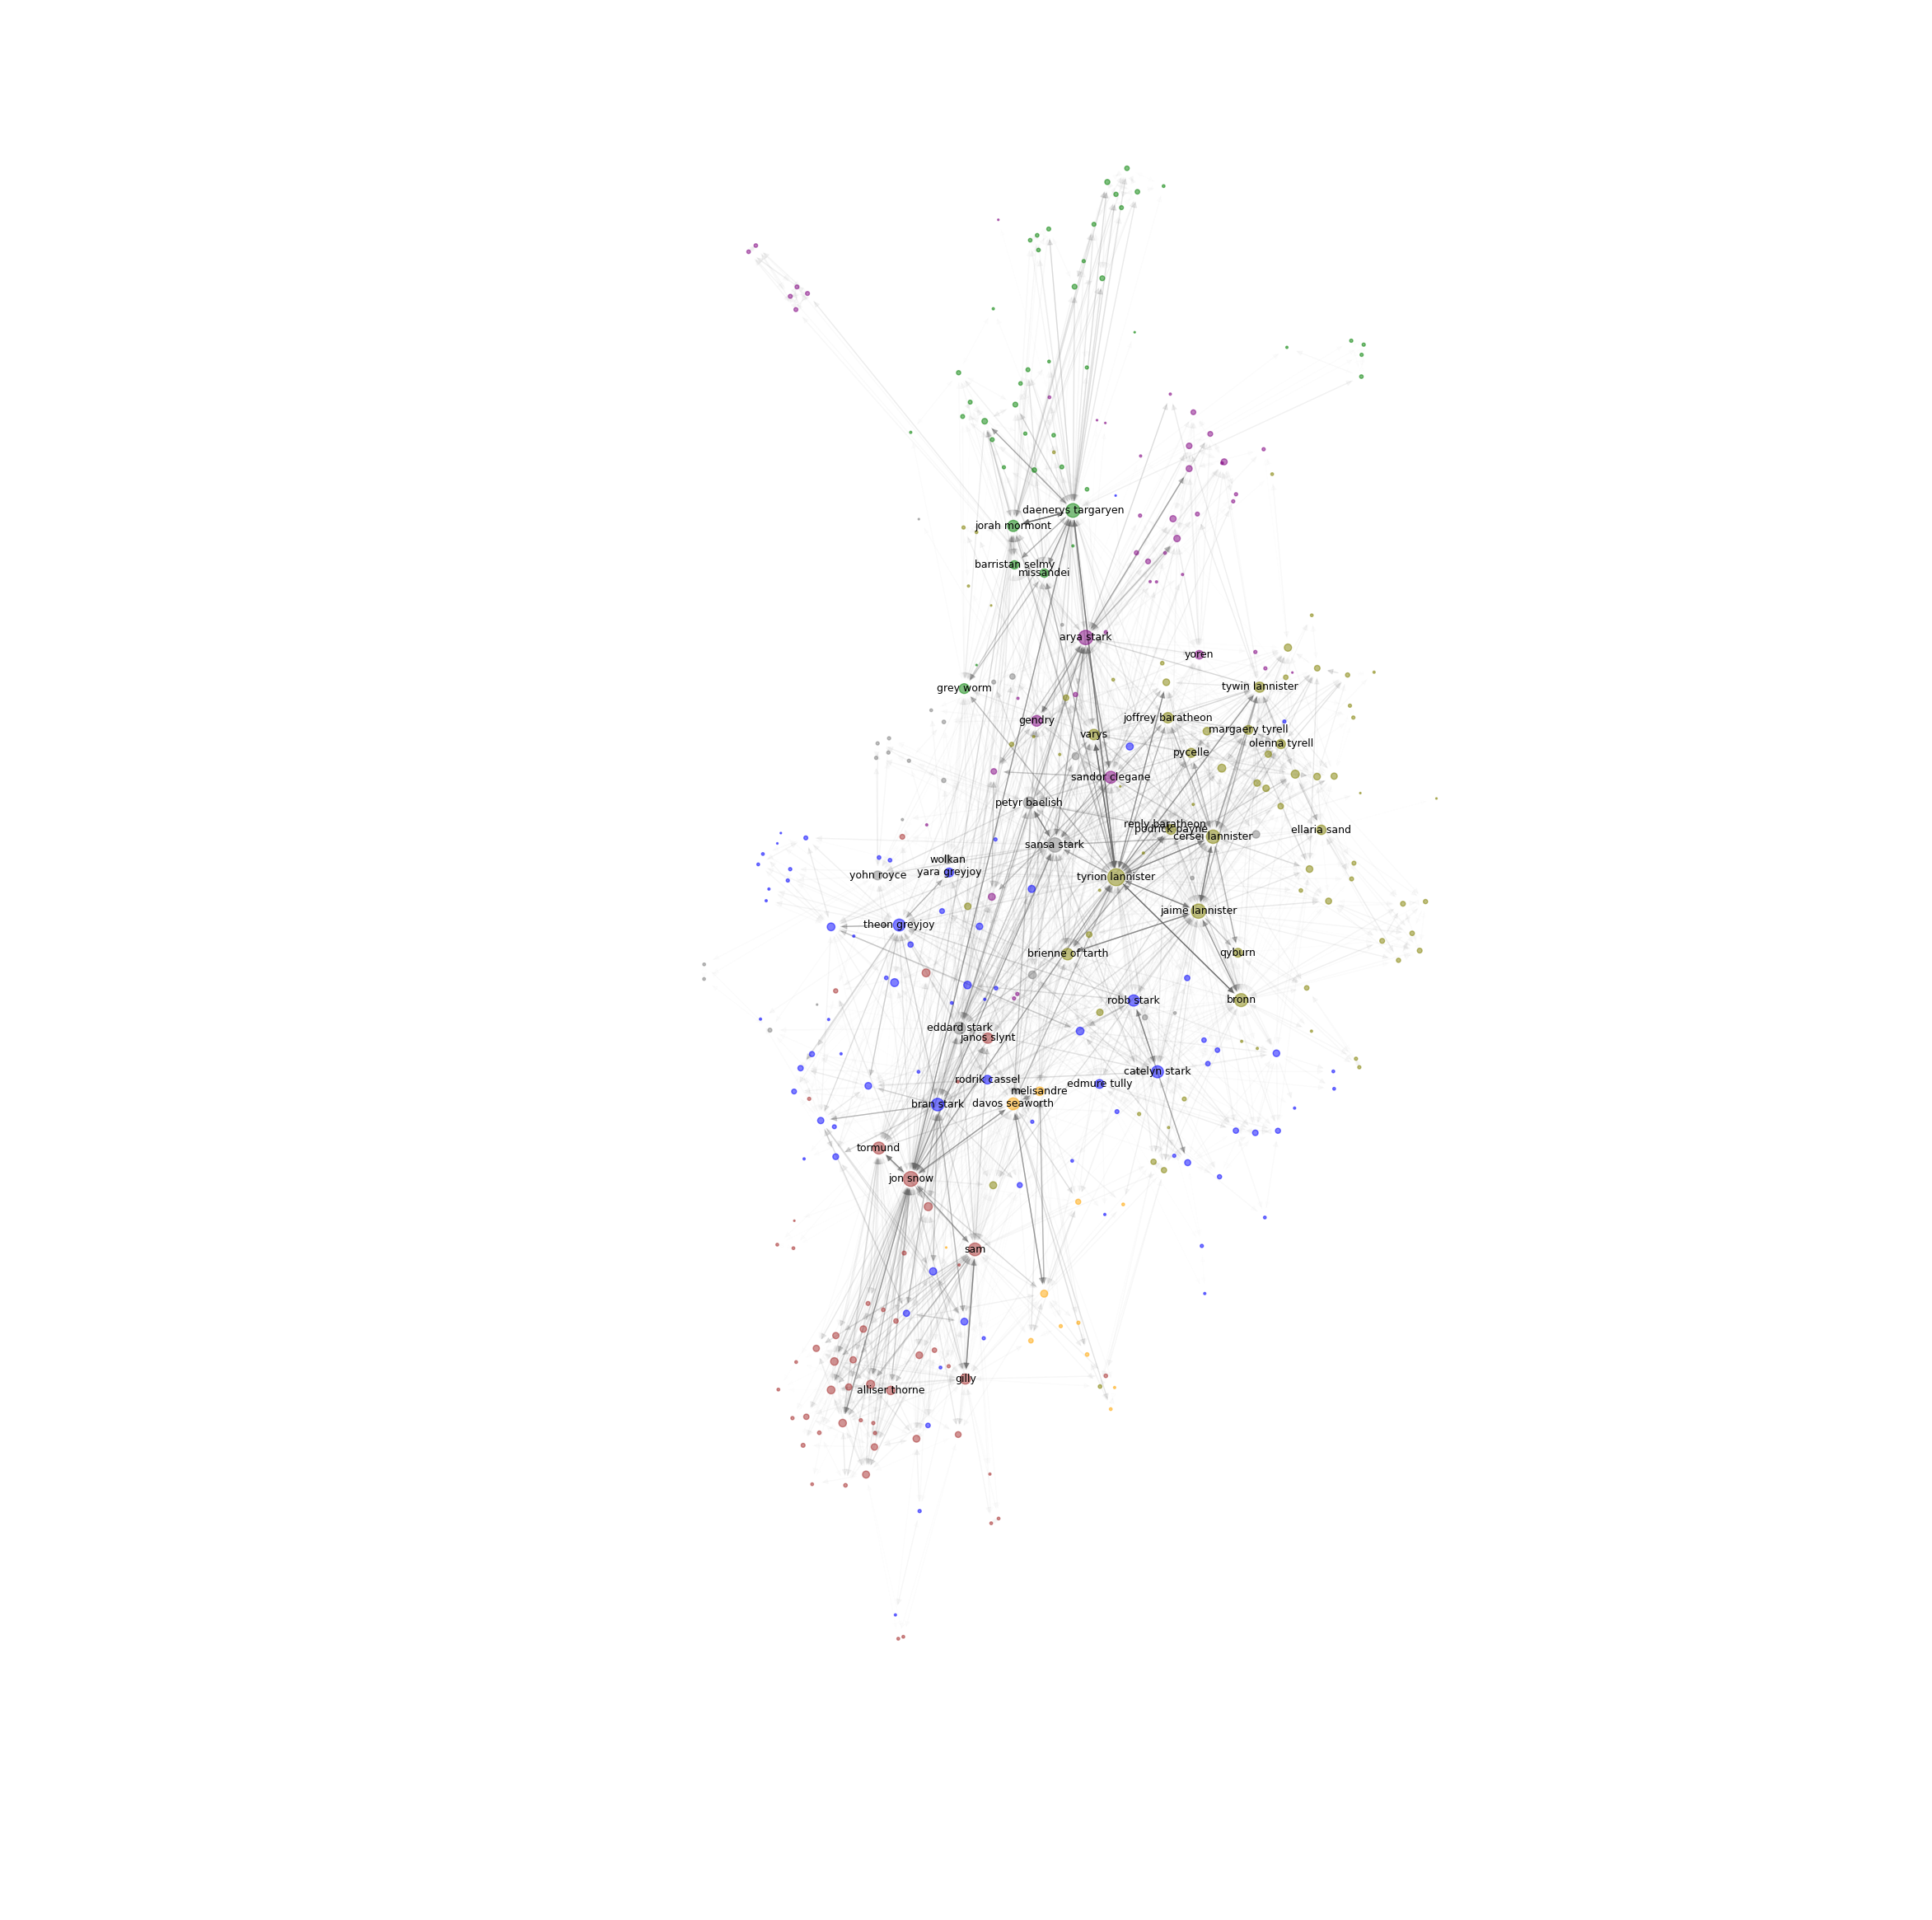

In [8]:
# Calling plot function 
plt.figure(figsize= (30,30))
PlotGrapWithComm(G, G)
plt.savefig("Network2.pdf")


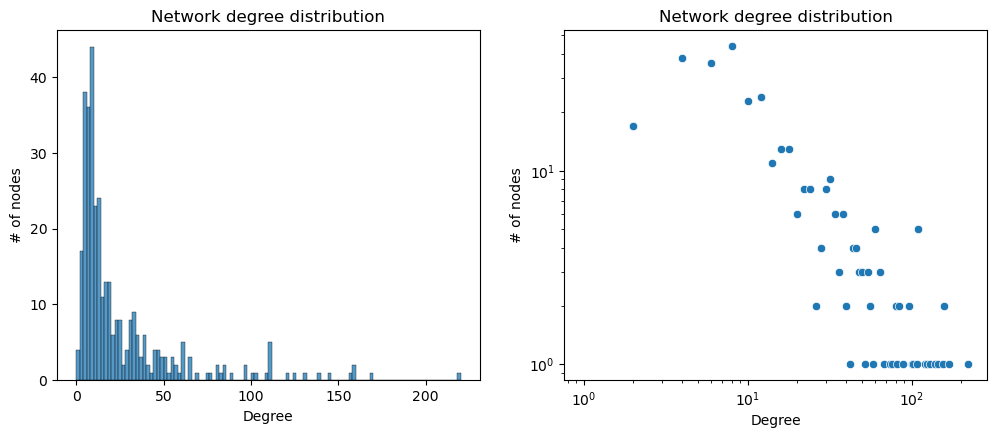

In [9]:
# Degree distribution plots 
degree_sequence = sorted((d for n, d in G.degree()), reverse =True)

INbins = np.arange(min(degree_sequence), max(degree_sequence)+1)

pmf = [(degree_sequence == bin).sum() for bin in INbins]
pmf = np.array(pmf)

plt.figure(figsize=(12,10))
plt.subplot(221)
sns.histplot(degree_sequence,binwidth = 2)
plt.title("Network degree distribution")
plt.ylabel("# of nodes")
plt.xlabel("Degree")

plt.subplot(222)
sns.scatterplot(y = pmf, x = INbins)
plt.title("Network degree distribution")
plt.ylabel("# of nodes")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Degree")
plt.show()

In [10]:
# Calculating (gamma) from the degree distribution
import powerlaw
print(powerlaw.Fit(degree_sequence).alpha)


Calculating best minimal value for power law fit
2.6120461668304276


Values less than or equal to 0 in data. Throwing out 0 or negative values


In [11]:
# Finding the longest shortest path in the network
ppp=nx.all_pairs_dijkstra_path_length(G)
longestShortest = 0
for i in ppp:
  node=max(i[1], key=i[1].get)
  if len(nx.shortest_path(G,i[0],node)) > longestShortest:
    longestShortest = len(nx.shortest_path(G,i[0],node))

print(longestShortest)

5


In [12]:
# Finding the nodes with the highest and the lowest degrees. The lowest is not very informative as it is of course very small characters
TotalSorted = max(dict(G.degree()).items(), key = lambda x : x[1])
print("Most connected character is", TotalSorted[0].title(),"with a degree of", TotalSorted[1], "" )
MostConnected = sorted(dict(G.degree).items(), key = lambda x : x[1], reverse= True)
LeastConnected = sorted(dict(G.degree).items(), key = lambda x : x[1])
print("The 10 most connected characters:")
[print(str(i+1)+".",w[0],"with", w[1], "edges" ) for w,i in zip(MostConnected, range(0,10))]
print("-"*50)
print("The 10 least connected characters:")
[print(str(i+1)+".",w[0],"with", w[1], "edges" ) for w,i in zip(LeastConnected, range(0,10))]
x = 1

Most connected character is Tyrion Lannister with a degree of 220 
The 10 most connected characters:
1. tyrion lannister with 220 edges
2. jon snow with 168 edges
3. arya stark with 158 edges
4. sansa stark with 158 edges
5. jaime lannister with 156 edges
6. daenerys targaryen with 144 edges
7. cersei lannister with 138 edges
8. bronn with 130 edges
9. sam with 124 edges
10. bran stark with 120 edges
--------------------------------------------------
The 10 least connected characters:
1. father with 0 edges
2. white rat with 0 edges
3. rennick with 0 edges
4. harpy with 0 edges
5. night's watchman with 2 edges
6. harrag with 2 edges
7. maggy with 2 edges
8. drogo with 2 edges
9. martha with 2 edges
10. drowned priest with 2 edges


In [13]:

TotalSorted = max(dict(G.degree()).items(), key = lambda x : x[1])
print("Most connected character is", TotalSorted[0].title(),"with a degree of", TotalSorted[1], "" )
MostConnected = sorted(dict(G.degree).items(), key = lambda x : x[1], reverse= True)
LeastConnected = sorted(dict(G.degree).items(), key = lambda x : x[1])
print("The 10 most connected characters:")
[print(str(i+1)+".",w[0],"with", w[1], "edges" ) for w,i in zip(MostConnected, range(0,10))]

Most connected character is Tyrion Lannister with a degree of 220 
The 10 most connected characters:
1. tyrion lannister with 220 edges
2. jon snow with 168 edges
3. arya stark with 158 edges
4. sansa stark with 158 edges
5. jaime lannister with 156 edges
6. daenerys targaryen with 144 edges
7. cersei lannister with 138 edges
8. bronn with 130 edges
9. sam with 124 edges
10. bran stark with 120 edges


[None, None, None, None, None, None, None, None, None, None]

In [14]:

#Calculating the total lines spoken by each character
TyrionLines = 0
weightDict = dict()

for FROM, TO in G.edges():
    if "weight" in G.edges[FROM,TO]:
        if FROM not in weightDict.keys():
            weightDict[FROM] = G.edges[FROM,TO]["weight"]
        else:
            weightDict[FROM] += G.edges[FROM,TO]["weight"]

# Printing the characters with the highest degrees' number of line spoken
print(weightDict["tyrion lannister"])
print(weightDict["jon snow"])
print(weightDict["daenerys targaryen"])
print(weightDict["jaime lannister"])
print(weightDict["sansa stark"])
print(weightDict["arya stark"])


4739
3432
2811
2015
1925
1640


In [15]:

# Lix Score function
def Lix(listoftext):
    senctenceList = listoftext
    P = len(senctenceList)
    L = 0
    O = 0
    for sentence in senctenceList:
        O += len(sentence.split(" "))
        for word in sentence.split(" "):
            if len(word) > 6:
                L += 1            
    lixNumber = O/P + L*100/O


    return lixNumber

In [17]:
# Extracts the text that each character speaks and adds it to a dictionary
textDict = dict()
textSet = set()
for FROM, TO in G.out_edges():
    for season, val in G.out_edges[(FROM,TO)].items():
        if season != "weight":
            for episode, val2 in val.items():
                for epiname,val3 in val2.items():
                    for location, val4 in val3.items():
                        for dialogue in val4.values():
                            for text in dialogue:
                                if text not in textSet:
                                    textSet.add(text)
                                    if FROM not in textDict.keys():
                                        textDict[FROM] = list()
                                    textDict[FROM].append(text)


In [18]:

#Calculate the lix score of the characters
lixDict = dict()
for key in textDict.keys():
    lixDict[key] = Lix(textDict[key])

# create a list of the houses the characters belong to
HouseList = []
for name in lixDict.keys():
    if "house" in G.nodes[name].keys():
        HouseList.append(G.nodes[name]["house"][0])
    elif "affiliation" in G.nodes[name].keys():
        HouseList.append(G.nodes[name]["affiliation"][0])
    else:
        HouseList.append("No House")
df = pd.DataFrame()

df["Houses"] = HouseList
df["Names"] = lixDict.keys()
df["Values"] = lixDict.values()
df =df.sort_values(by="Houses")

In [33]:
#Create two node lists. One where characters have over 50 degrees and one where they have over 15
# To be used to limit data amount and to not include characters that have very few lines of dialogue
Over50DegreeList = [x for x in G.nodes() if G.degree(x) > 50]
Over15DegreeList = [x for x in G.nodes() if x in weightDict.keys() and weightDict[x] > 50]
df2 = df.loc[df["Names"].isin(Over50DegreeList)]
df3 = df.loc[df["Names"].isin(Over15DegreeList)]

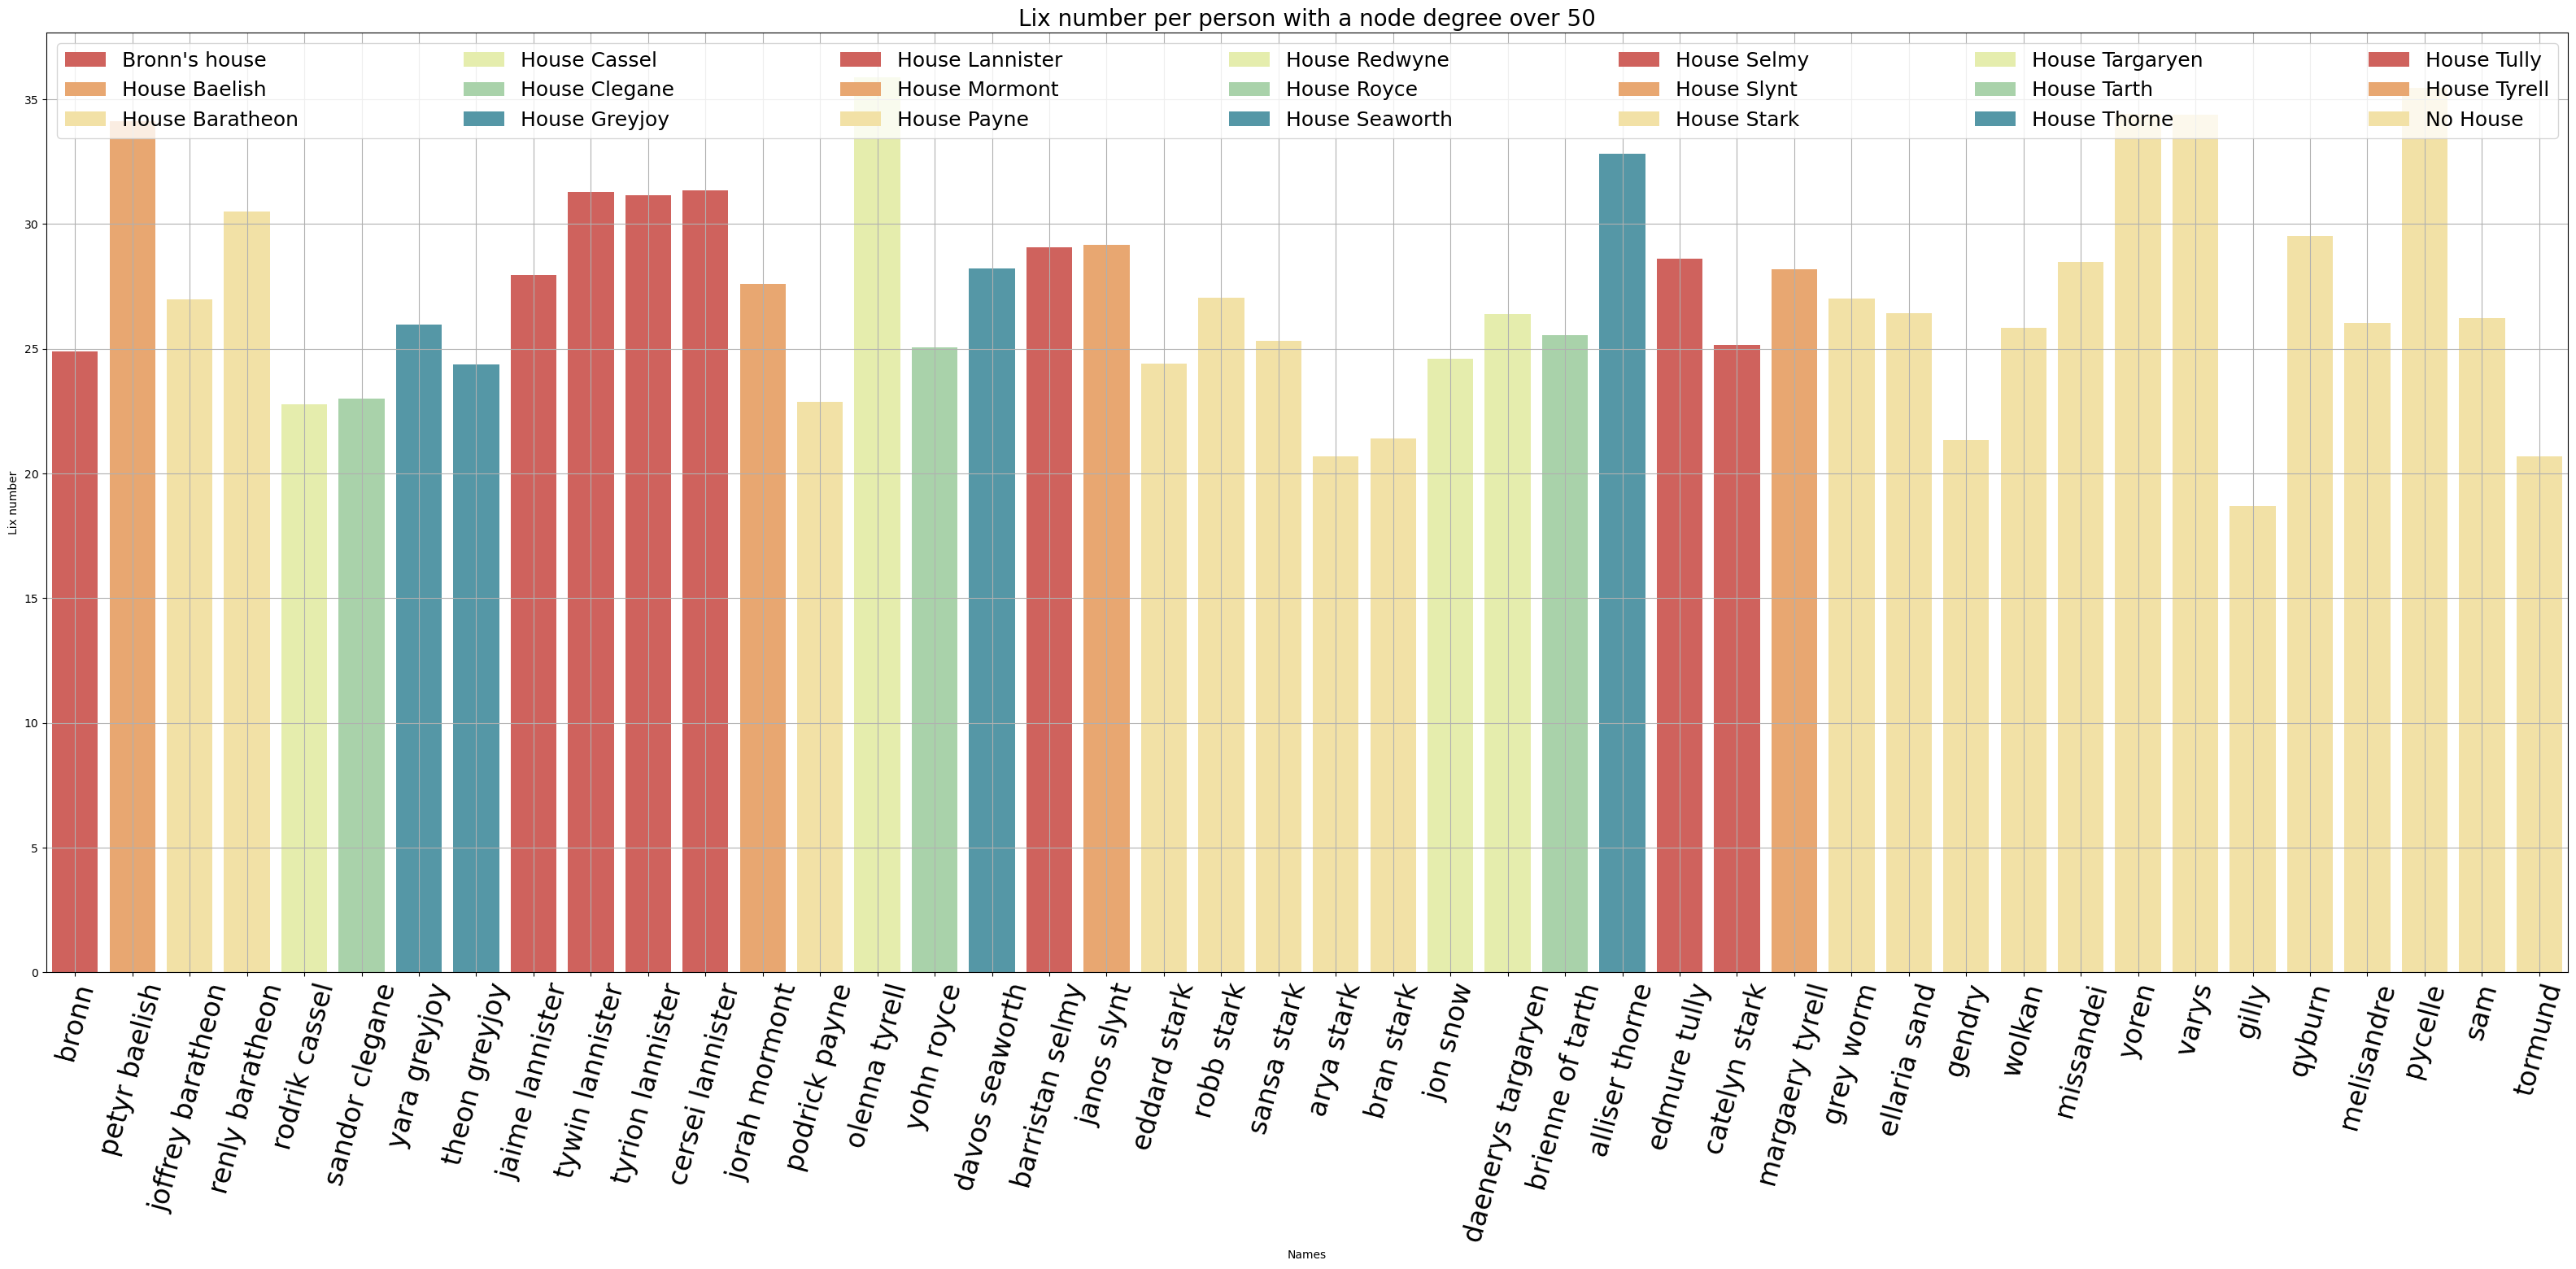

In [29]:
# Plotting the barchart of the lix scores
plt.figure(figsize=(40,15))
ax = sns.barplot(y = "Values", x= "Names", hue = "Houses",data = df2, dodge=False, palette= sns.color_palette("Spectral"))
plt.title("Lix number per person with a node degree over 50", fontsize = 20)
plt.ylabel("Lix number")
plt.grid(True,which="major")
sns.move_legend(ax,loc="upper center")
plt.xticks(rotation = 75, fontsize = 24)
plt.legend(mode = "expand",   ncol = 7, fontsize = 18)
plt.show()

In [40]:
import random
random.seed(100)
# Calculating the mean of the Lannister Lix scores
LannisterMean = (lixDict["jaime lannister"] + lixDict["tywin lannister"]+ lixDict["tyrion lannister"]+ lixDict["cersei lannister"])/4
lixNumbers = list(lixDict.values())

#Creating a list of of means from randomly chosen lix values
meanList = []
N = 10000
for i in range(N):
    unshuffledList = list(df3["Values"])
    random.shuffle(unshuffledList)
    avg = np.mean(unshuffledList[0:4]) #Taking the mean of randomly chosen lix values 
    meanList.append(avg) 
meanList = np.array(meanList)

# Reporting the percentage of means that higher than the Lannister mean
print(len(meanList[meanList>LannisterMean])/N *100,"%")

6.7 %


<h1>This whole section of wordclouds and sub graphs is not used</h1>

In [ ]:
import wordcloud
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords

TextList = ["" for i in range(8)]
TextSet = set()

# Extract the text from each edge
for i in range(1,9):
    tmpText = ""
    for _,_,att in G.edges(data=True):
        if i in att["lines"].keys():
            for episodeNr, value in att["lines"][i].items():
                for episode, value2 in value.items():
                    for scene, lines in value2.items():
                        if "".join(lines).strip() not in TextSet:
                            TextSet.add("".join(lines).strip())
                            tmpText += "".join(lines).strip()
    TextList[i-1] = nltk.word_tokenize(tmpText)

FinalTextList = list()
wnl = nltk.WordNetLemmatizer()



In [ ]:
# Removing stop words and non words. NOT USED
for lists in TextList:
    tmpList = [wnl.lemmatize(x.lower()) for x in lists if re.match("\w", x) != None and x.lower() not in stopwords.words("english") and x.lower() not in ["n't","lt","lf","l","u"]]
    k = nltk.FreqDist(tmpList)
    FinalTextList.append(k)

In [ ]:
#  Extracting the frequencies of the words in the dialogue. NOT USED
tftrList = list()
FreqDict = dict()
c = 8
for i in range(8):
    FreqDict = dict()
    for word, count in FinalTextList[i].items():
        weight = 0
        for k in range(len(FinalTextList)):
            if k != i:
                weight += FinalTextList[k][word]
        FreqDict[word] = count/(1/7*weight+c) # We divide the weight by seven to show what words are overrepresented in each season
    tftrList.append(FreqDict)


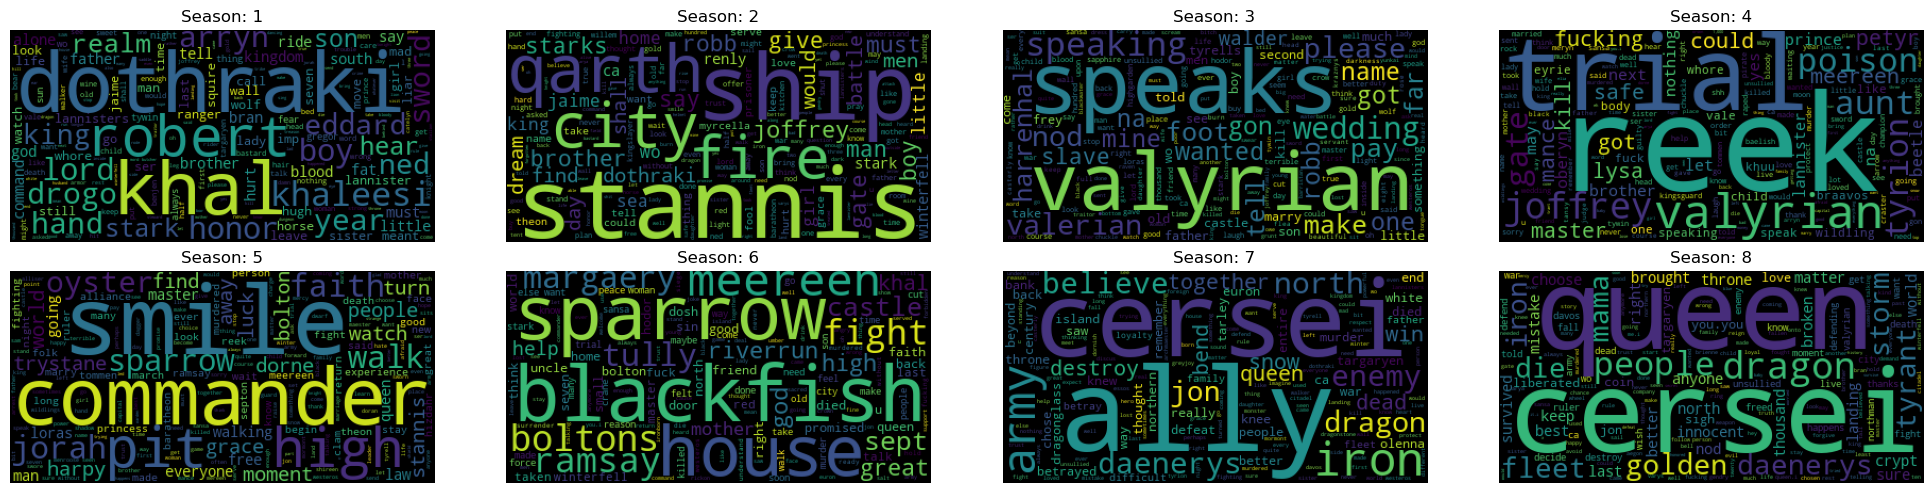

In [ ]:
# Plotting the wordclouds NOT USED
plt.figure(figsize=(20,5))
for i in range(len(tftrList)):
    plt.subplot(241+i)
    WC = WordCloud(collocations=False).generate_from_frequencies(tftrList[i])
    plt.title("Season: "+ str(i+1))
    plt.imshow(WC)
    plt.axis('off')
    
plt.tight_layout() 
plt.show()

    

In [ ]:

### Creating sub plots for each season. NOT USEED

SeasonNodesList = list()
EdgeList = list()

for i in range(0,8):
    SeasonNodesList.append(set())
    EdgeList.append(list())
    for FROM, TO in G.edges():
        if i+1 in G.edges[FROM,TO]["lines"].keys():
            SeasonNodesList[i].add(FROM)
            SeasonNodesList[i].add(TO)
            EdgeList[i].append((FROM,TO))

FinalSeasonNodesList = [list(x) for x in SeasonNodesList]
EdgeSubGraphs = [G.edge_subgraph(x) for x in EdgeList]
NodeSubGraphs = [G.subgraph(x) for x in FinalSeasonNodesList]
plt.figure(figsize=(20,10))
for i in range(len(NodeSubGraphs)):
    plt.subplot(241+i)
    PlotGrapWithComm(NodeSubGraphs[i], EdgeSubGraphs[i], 50)
    plt.title("Season: "+ str(i+1))
    
plt.tight_layout() 
plt.show()
